In [44]:
library(tidyverse)
library(tidymodels)
library(repr)
library(GGally)
install.packages("themis")
library(themis)

set.seed(3)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



# DSCI 100 : Group Project
## Tony, Mikki, Daisy

### Introduction

We will be using the multivariable Heart Disease Data in the UCI Machine Learning Repository (1988) to predict the presence of cardiovascular disease. In this dataset, the presence of cardiovascular disease is determined by the vessel diameter narrowing. Lower than 50% diameter narrowing in patients is assumed to indicate the absence of heart disease. On the other hand, higher than 50% diameter narrowing in patients is assumed to indicate the presence of heart disease. We hope to determine whether ST depression (Kligfield, P., 2006) induced by exercise relative to rest (oldpeak), age, maximum heart rate achieved (thalach), and cholesterol levels (chol) of patients can predict the presence of cardiovascular disease. ST depression (Miranda et al., 1991), age (Sandvik, L., et al., 1995), cholesterol, and max heart rate (Jeong et al., 2018) were all chosen because previous research has shown their ability to indicate circulatory health; especially in the context of cardiovascular disease onset.

### Data Analysis

In [45]:
#tidying from prelim.
options(repr.plot.width=10, repr.plot.height=7)

url<-"https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
heart_data_raw<-read_csv(url)
colnames(heart_data_raw)<- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "cvd")
heart_data<-heart_data_raw %>%
    select(chol, cvd, age, thalach, oldpeak) 


heart_data$cvd[heart_data$cvd == "2"] <- "1"
heart_data$cvd[heart_data$cvd == "3"] <- "1"
heart_data$cvd[heart_data$cvd == "4"] <- "1"
heart_data$cvd[heart_data$cvd == "1"] <- "presence"
heart_data$cvd[heart_data$cvd == "0"] <- "absence"

heart_data <- heart_data %>%
    mutate(cvd = as_factor(cvd))
heart_data_na<- heart_data %>% 
    is.na() %>%
    sum()
heart_data_na
head(heart_data) 

New names:
• `1.0` -> `1.0...2`
• `1.0` -> `1.0...3`
• `1.0` -> `1.0...6`
• `0.0` -> `0.0...9`
• `0.0` -> `0.0...12`
Rows: 302 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): 0.0...12, 6.0
dbl (12): 63.0, 1.0...2, 1.0...3, 145.0, 233.0, 1.0...6, 2.0, 150.0, 0.0...9...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 0

chol,cvd,age,thalach,oldpeak
<dbl>,<fct>,<dbl>,<dbl>,<dbl>
286,presence,67,108,1.5
229,presence,67,129,2.6
250,absence,37,187,3.5
204,absence,41,172,1.4
236,absence,56,178,0.8
268,presence,62,160,3.6


Our first step was to upload the data from the url into R. When initially loaded, the data table did not include legible column names. To fix this, we used the colnames() function to add readable names by comparing it with the url's version (which included proper titles). We then selected for the desired variables discussed in our introduction. The original data used untegers ranging from 1-4 to identify the type of cardiovacular disease. Since we are merely predicting the presece of it and not the type, we changed the integers corresponing to the presence of cvd to "presence" and the other integer to "absence". This made the data easier to interpret and human legible. Finally, we made sure to convert these new variables to factor values for compatibility with later coding steps. We can also conclude that there are no NA values in our dataset, because using the is.na and sum() functions would give a count of how many values in our dataset were "TRUE" for being "NA".  

In [46]:
#summary table
summary_mean <- heart_data |> 
select (-cvd) |>
map_df(mean)

summary_class_count <- heart_data |>
group_by(cvd) |>
summarize("observation_count" = n())

summary_table <- bind_cols(summary_mean, summary_class_count)

summary_table 

chol,age,thalach,oldpeak,cvd,observation_count
<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<int>
246.7384,54.4106,149.606,1.03543,presence,139
246.7384,54.4106,149.606,1.03543,absence,163


In the summary table above, we have calculated the mean values of each of our predictors and found the number of observations for each class. Given that there is a fairly large discrepancy between the mean values of the different predictors (oldpeak being 1 and cholesterol in the hundreds), we believe that scaling the values is also important when building the KNN model.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



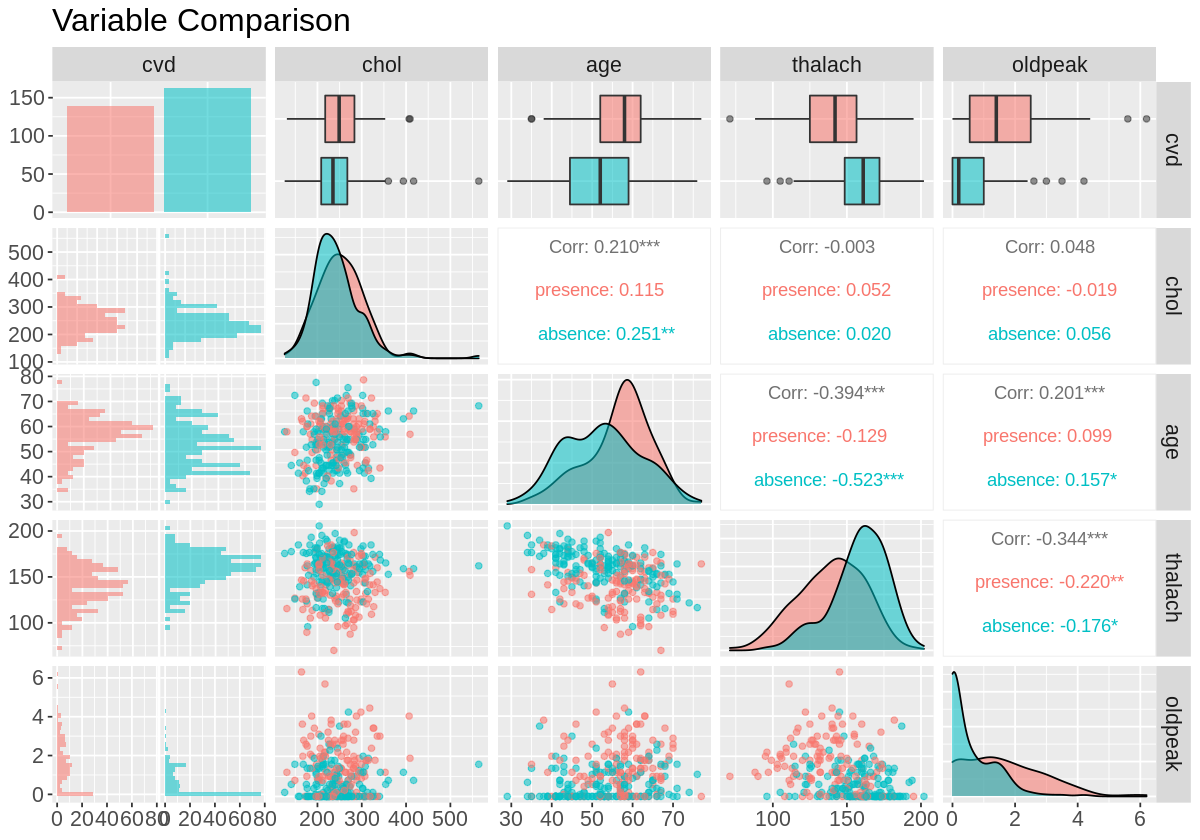

In [47]:
#ggpairs to comapre varaibles
set.seed(3)
heart_pairs <- heart_data |> 
select(cvd, chol, age, thalach, oldpeak) |>
ggpairs(mapping=ggplot2::aes(colour = cvd, alpha = 0.3)) +
        ggtitle("Variable Comparison") +
    theme(text = element_text(size = 16)) 

heart_pairs

Visualizing our diagram using ggpairs, we can create boxplots that show the range of values that each class, red being absence and blue being presence, fall under for each predictor. Through this, we can determine the strength of each correlation. In this visualization, cholesterol appears to be the worst predictor as the median and the Interquartile range of values for absence and presence are almost identical. On the other hand, ST depression induced by exercise relative to rest (oldpeak) and maximum heart rate achieved (thalach) seems to have much more distinct regions for presence and absence. 

The box plots also tells us that the lowest values of age tend to correlate with the absence of cvd while highest values of age tend to correlate with the presence of cvd; however, the middle values seem to be more blended. Similarily, lower values of thalach tends to correlate with the presence of cvd while higher values of thalach tends to correlate with the absence of cvd. Finally, lower values of oldpeak tends to correlate with the absence of cvd while higher values of oldpeak tends to correlate with the presence of cvd.

chol,cvd,age,thalach,oldpeak
<dbl>,<fct>,<dbl>,<dbl>,<dbl>
286,presence,67,108,1.5
229,presence,67,129,2.6
250,absence,37,187,3.5
204,absence,41,172,1.4
236,absence,56,178,0.8
268,presence,62,160,3.6


size,model_string,accuracy
<int>,<chr>,<dbl>
1,cvd ~ oldpeak,0.7088210
2,cvd ~ oldpeak+thalach,0.7353274
3,cvd ~ oldpeak+thalach+age,0.7421071
4,cvd ~ oldpeak+thalach+age+chol,0.7256025


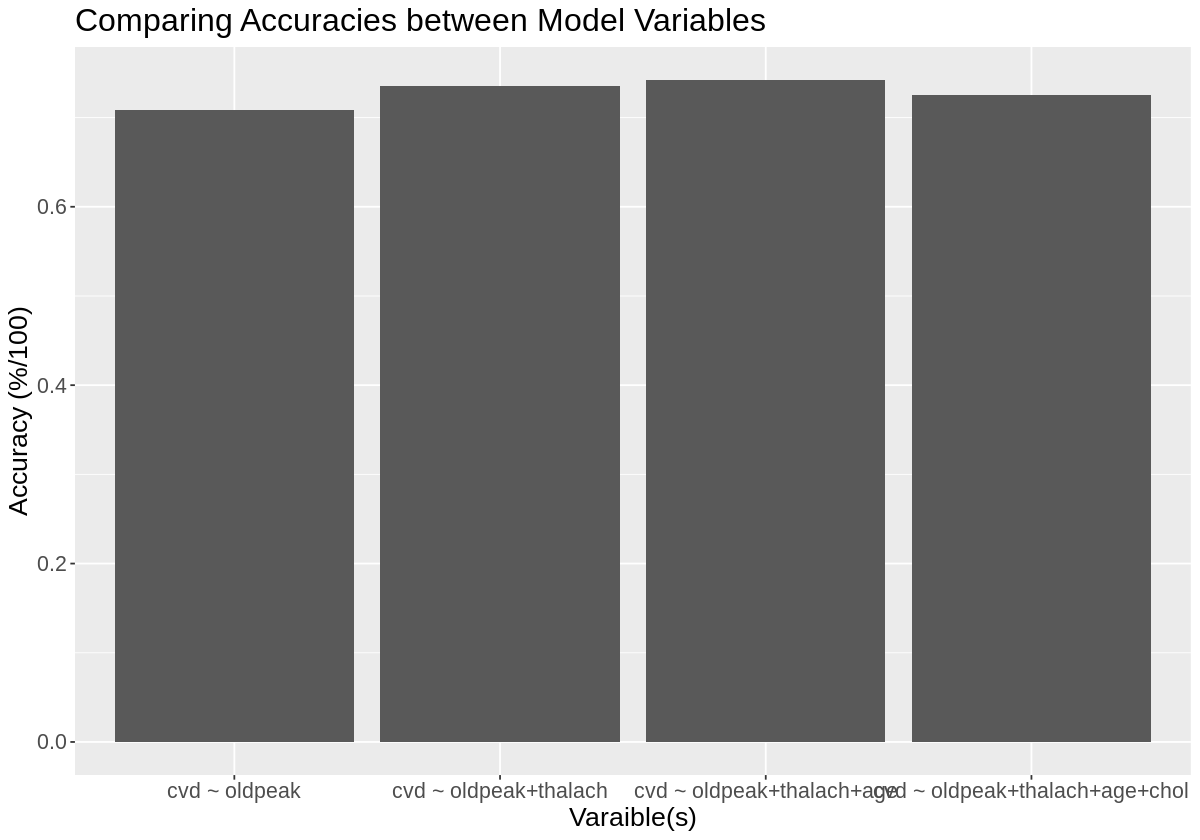

In [48]:
#Forward Selection
set.seed(3)
hd_subset <- heart_data
names <- colnames(hd_subset |> select(-cvd))
head(hd_subset)
example_formula <- paste("cvd", "~", paste(names, collapse="+"))
# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())
# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")
# create a 5-fold cross-validation object
hd_vfold <- vfold_cv(hd_subset, v = 5, strata = cvd)
# store the total number of predictors
n_total <- length(names)
# stores selected predictors
selected <- c()
# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("cvd", "~", paste(preds_new, collapse="+"))
 # create a recipe from the model string
        hd_recipe <- recipe(as.formula(model_string), 
                                data = hd_subset) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())
 # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(hd_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = hd_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()
# add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies
comparison_vis<-accuracies %>%
    ggplot(aes(x = model_string, y = accuracy)) +
    geom_bar(stat = "identity") +
    labs(x = "Varaible(s)" , y = "Accuracy (%/100)") +
    theme(text = element_text(size = 16)) +
    ggtitle("Comparing Accuracies between Model Variables")
comparison_vis

We will use forward selection to find a good subset of predictors with higher accuracy. First we start a no predictors model, and create an empty tibble to store the accuracy for each predictors. We create a KNN specification model with adding each unused predictors to the model until all of them exist in the model to finding out the accuracy. We tune the KNN classifier with these predictors and collect the accuracy for the best K.

From the bar chart we can see that when the predictor is only the oldpeak, the accuracy is the lowest at 70.9%.  we add one more predictor (thalach), the accuracy increases to 73.5%. Then with additional age as a predictor, the accuracy is almost 74.2% which is the highest. However, when we use 4 variables as predictors, the accuracy decreases to 72.6%, which can tell us not always more predictors lead to high accuracy.

In [52]:
set.seed(3)
#split data into training part and testing part
hd_split<- initial_split(heart_data,prop=0.75, strata = cvd)
hd_train <- training(hd_split)
hd_test <- testing(hd_split)
#create validaiton model
heart_spec_vf<-nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification") 

#recipe and standadize for valid.
hd_recipe <- recipe(cvd~ age + thalach + oldpeak, data = hd_train)|>
step_scale(all_predictors())|>
step_center(all_predictors()) 

#vfold 
heart_vfold<-vfold_cv(hd_train, v = 5 , strata = cvd)
#fit using workflow
heart_wf_vf<-workflow() %>%
    add_recipe(hd_recipe) %>%
    add_model(heart_spec_vf) %>%
    tune_grid(resamples = heart_vfold, grid = 150) %>%
    collect_metrics() 

After setting the random seed at 3 to ensure replicable randomness, we split the data into training and testing parts. The training set holds 75% of the data while the testing set holds the remaining 25%. We then proceeded with data preprocessing using recipe to step_scale and step_center our predictors for better visualization. From then on, we created a 5-fold cross-validation model and used grid = 150 because it will test k values up to half the data points within our dataset. 

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
13,accuracy,binary,0.7438296,5,0.02584174,Preprocessor1_Model13


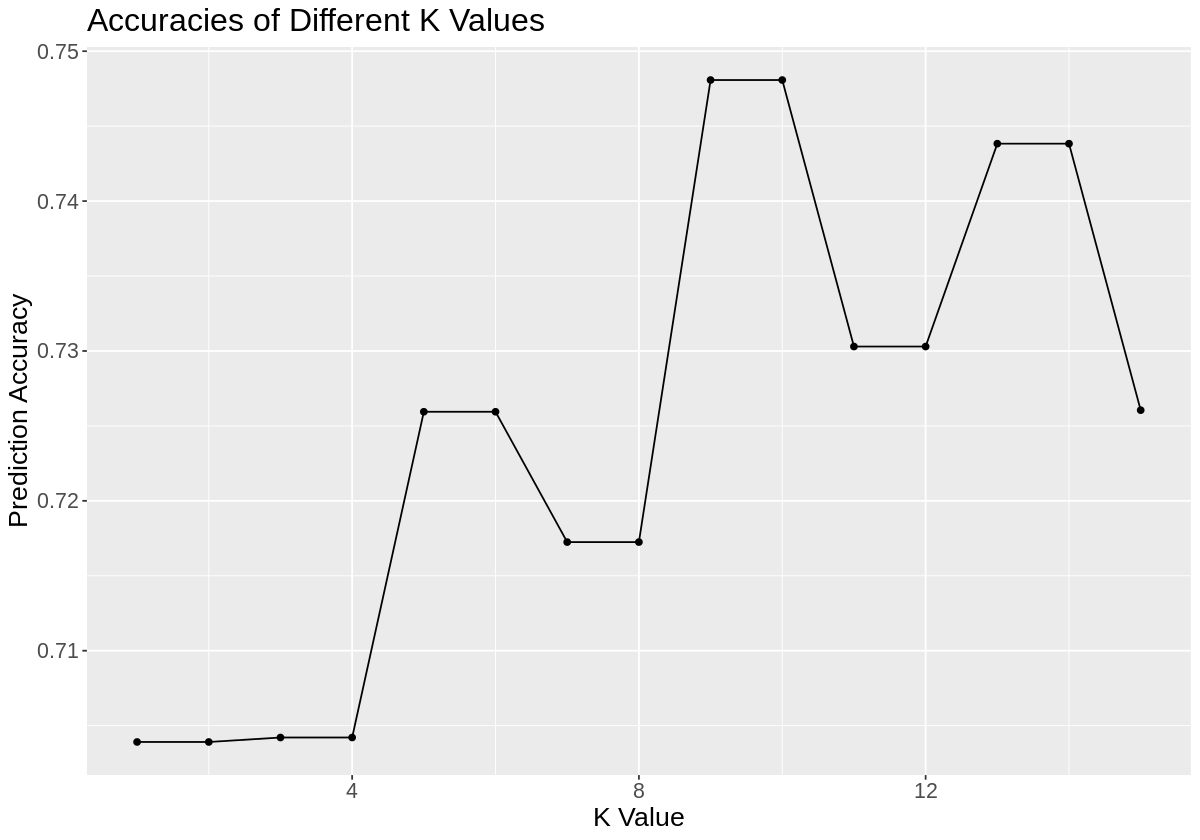

In [53]:
set.seed(3)
#comupte accuracy of vfold
wf_accuracy<-heart_wf_vf %>%
    filter(.metric == "accuracy") 
wf_max<- wf_accuracy %>%
    arrange(desc(mean)) %>%
    slice(3)
wf_max
#visualize k plot
k_plot<-wf_accuracy %>%
    ggplot(aes(x = neighbors , y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "K Value" , y = "Prediction Accuracy") +
    ggtitle("Accuracies of Different K Values") +
    theme(text = element_text(size = 16)) 
k_plot

Filtering the values of K by descending order based on the accuracy, we are able to extract the k value with the highest accuracy. We then created a plot for the different K values and found that 5 neighbors is one of the values with the highest accuracy. 

In [55]:
set.seed(3)
#using best k, re create model
heart_spec<-nearest_neighbor(weight_func = "rectangular", neighbors = 5) %>%
    set_engine("kknn") %>%
    set_mode("classification")
#put new model into workflow
heart_wf<- workflow() %>%
    add_recipe(hd_recipe) %>%
    add_model(heart_spec) %>%
    fit(data = hd_train)

#predict testing using all variables and accuracy
hd_predict<- predict(heart_wf, hd_test) %>%
    bind_cols(hd_test) %>%
    metrics(truth = cvd, estimate = .pred_class) %>%
    filter(.metric == "accuracy")

hd_predict

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6578947


Warning message:
“Removed 30 rows containing missing values (geom_point).”


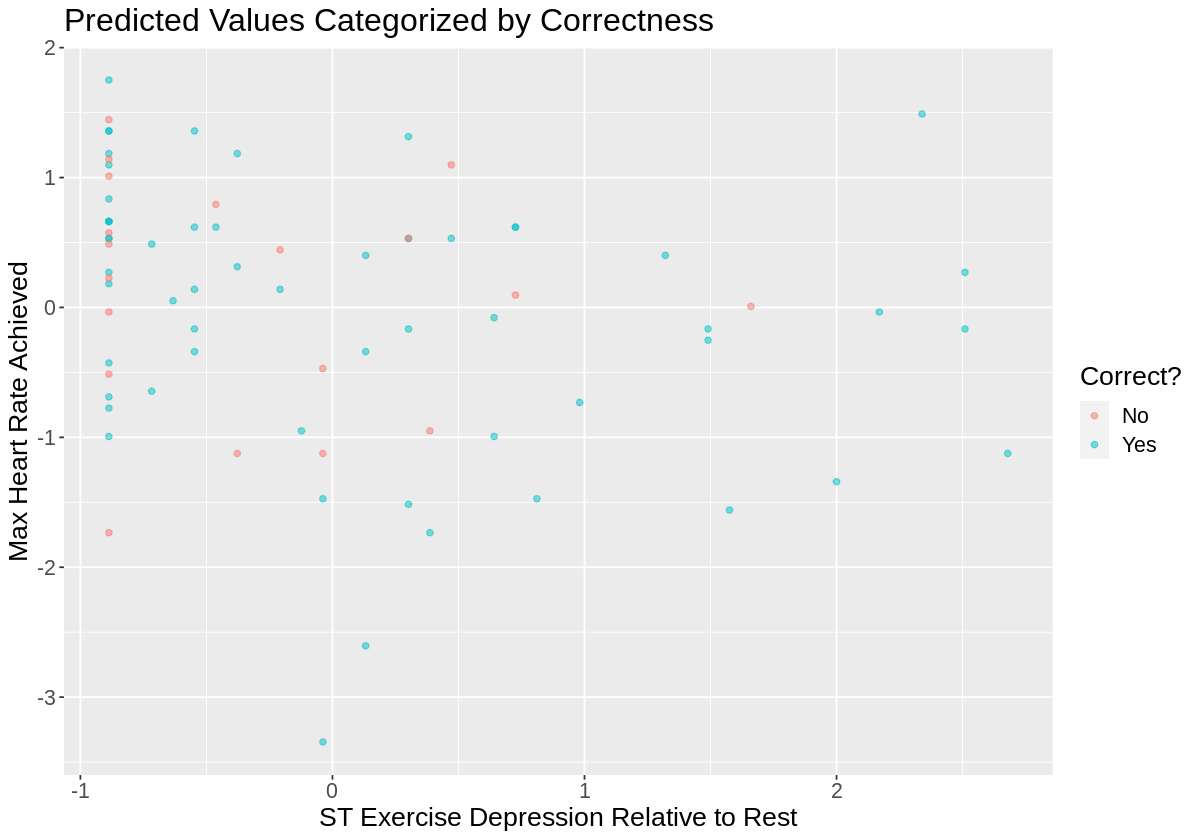

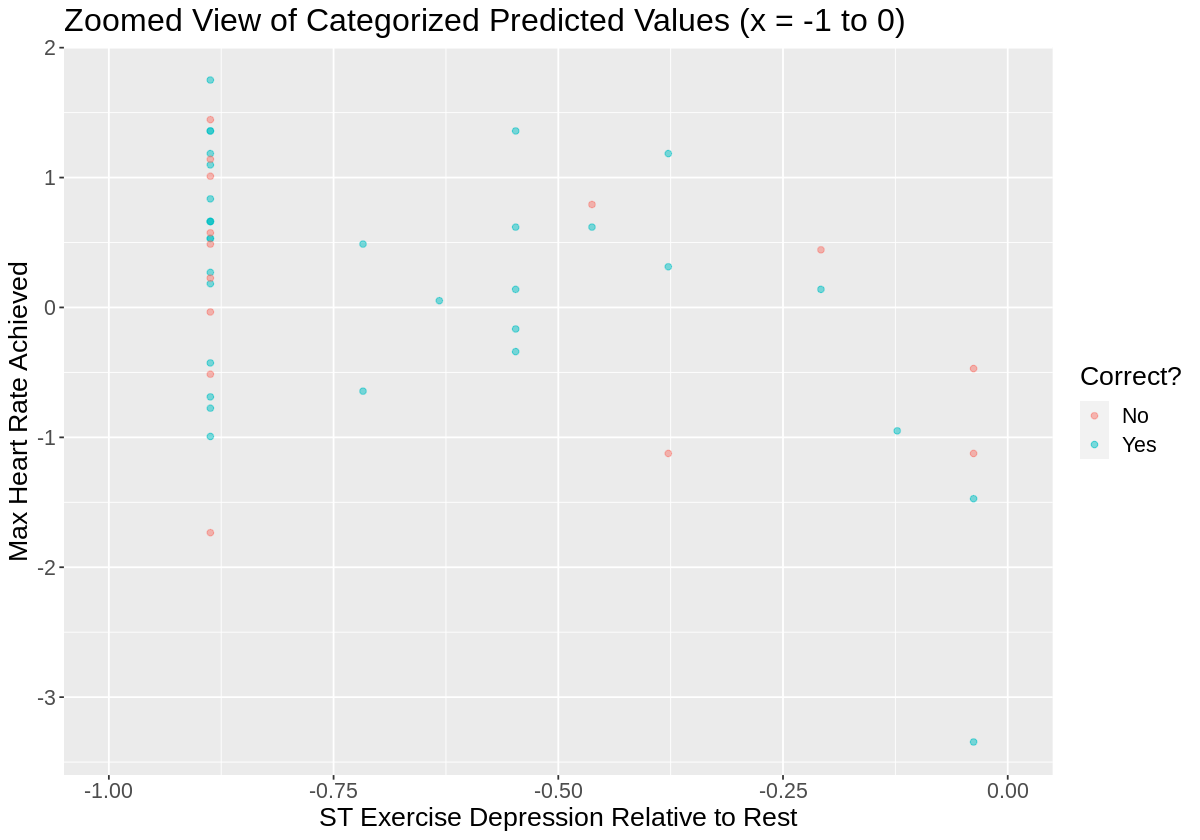

In [56]:
set.seed(3)
#use predict and accuracy on oldpeak and thalach 
two_recipe<-recipe(cvd~ oldpeak + thalach, data = hd_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) 
two_wf<- workflow() %>%
    add_recipe(two_recipe) %>%
    add_model(heart_spec) %>%
    fit(data = hd_train) 
two_predict<-predict(two_wf, hd_test) %>%
    bind_cols(hd_test)

#separate on whether prediciton was correct or not
correct<- two_predict %>%
    filter(.pred_class == cvd) %>%
    select(-age, -chol) %>%
    mutate(matching = "Yes")
incorrect<-two_predict %>%
    filter(.pred_class != cvd) %>%
    select(-age, -chol) %>%
     mutate(matching = "No") 

#recombine data with a row to show if pred. was correct then visualize
combined<-bind_rows(correct, incorrect) %>%
    mutate(thalach = scale(thalach)) %>%
    mutate(oldpeak = scale(oldpeak))
combined_vis<- combined %>%
    ggplot(aes(x = oldpeak , y = thalach, color = matching)) +
    geom_point(alpha = 0.5) +
    labs(x = "ST Exercise Depression Relative to Rest" , y = "Max Heart Rate Achieved", color = "Correct?") +
    theme(text = element_text(size = 16)) +
    ggtitle("Predicted Values Categorized by Correctness") 
combined_vis 
#zoom in on closely located points
combined_zoom <- combined %>%
    ggplot(aes(x = oldpeak , y = thalach, color = matching)) +
    geom_point(alpha = 0.5) +
    labs(x = "ST Exercise Depression Relative to Rest" , y = "Max Heart Rate Achieved", color = "Correct?") +
    theme(text = element_text(size = 16)) +
    ggtitle("Zoomed View of Categorized Predicted Values (x = -1 to 0)") +
    xlim(-1,0)
combined_zoom

From the graphs, we noticed that with higher levels of oldpeak, there seems to be a very low occurrence of incorrect values. With thalach, lower values seem to give us more correct values, however, this is not definitive as there is a significantly less proportion of those values. Zooming in on the densely populated points, we see that the errors seem to be more random and that no definitive pattern appears to emerge. 

### Discussion

Using these results, we hope to aid the healthcare systems in creating a more efficient, systematic, and accurate way of determining the presence of cardiovascular heart disease (CVD) among patients based on the quantitative measures of their symptoms. According to previous research, both oldpeak (ST depression induced by exercise relative to rest) and age have a strong potential to predict the onset of heart disease (Sandvik, L., et al., 1995)(National Institutes of Health, 2018). Previous research has also depicted a correlation between fluctuating cholesterol and heart disease deaths (BMJ, 2009), however, the data is less definitive in comparison. The above research has also indicated that ST depression, age, and cholesterol will positively correlate with CVD, while maximum heart rate will negatively correlate. Thus, we predicted that all variables will adequately predict the presence of CVD with ST depression and age having the strongest relationship out of the predictors.

However, after our extensive data analysis, the results were not what we anticipated. Though we were able to accurately predict the trend of the correlations, the strength of each predictor did not match with we had predicted. We found that both cholesterol and age are weaker predictor as we had initially expected. When including them into the model, the accuracy appears to go down. From the final bar chart plotted, we found that the classifier with thalach (maximum heart rate achieved) and oldpeak has the highest accuracy at 73.2% when applied to the test data set. Nonetheless, in a clinical setting, this accuracy would still not be sufficient enough for practical use as a 26.8% error in determining the presence of a potentially fatal disease can be catastrophic. Yet, despite this, our investigation has demonstrated that models using quantitative measures of symptoms have the capability to deduce medical conditions such as CVD. 

One key improvement that could be made to our model would be the use of the step_upsample() to balance the two types of observations in our trainig set. When there is an uneven number of absence vs presence values, the model may be swayed to predict the majority- desipte this not being true to the overall pattern. Although we attempted to use this in our model, we came across mutiple error messages and the professor/TAs could not determine why this was so.  Our investigation could prompt future questions such as could other factors like the frequency of smoking or certain Inborn deficiencies influence the onset of cardiovascular heart disease? Could there be a model that can predict the type of cardiovascular heart disease experienced by a patient (ie. coronary, stroke, peripheral arterial, and aortic)?

### References

Asia Pacific Cohort Studies Collaboration, Nov 21st (2005), Joint Effectos of Systolic Blood Pressure and Serum Cholestrol on Cardiovascular Disease in the Asia Pacific Region, 112:3384-3390, https://www.ahajournals.org/doi/full/10.1161/CIRCULATIONAHA.105.537472
  
  BMJ, Feb 16th (2009), Assicoation between Change in High Density Lipoprotein Cholestrol and Cardiovascular Disease Morbidity and Mortality: Systematic Review and Meta-regression Analysis, 338;b92
https://www.bmj.com/content/338/bmj.b92.short 
   
   Jeong, Su-Min, et al., (2018). Effect of Change in Total Cholesterol Levels on Cardiovascular Disease Among Young Adults. Journal of the American Heart Association, Vol. 7, No 12.DOI: 10.1161/JAHA.118.008819 
https://www.ahajournals.org/doi/10.1161/JAHA.118.008819
  
  Kligfield, Paul, Lauer, Michael S., Nov 7 (2006), Exercise Electrocardiogram Testing: Beyond the ST Segment, 114;2070-2082, https://www.ahajournals.org/doi/10.1161/CIRCULATIONAHA.105.561944
  
  Miranda, C. P., Lehmann, K. G., & Froelicher, V. F. (1991). Correlation between resting ST segment depression, exercise testing, coronary angiography, and long-term prognosis. American heart journal, 122(6), 1617–1628. 
https://pubmed.ncbi.nlm.nih.gov/1957757/
   
   National Institutes of Health, June 1st (2018), Heart Health and Aging, 
https://www.nia.nih.gov/health/heart-health-and-aging
  
  Sandvik, L., Erikssen, J., Ellestad, M., Erikssen, G., Thaulow, E., Mundal, R., Rodahl, K., August 6th (1995), Heart Rate Increases and Maximal Heart Rate during Excercise as Predictors of Cardiovascular Mortality: A 16-year Follow-up Study of 1960 Healthy Men, (8):667-79, 
https://pubmed.ncbi.nlm.nih.gov/8574463/
  
  UCI Machine Learning Repository, (1988), Heart Disease Data Set,
https://archive.ics.uci.edu/ml/datasets/Heart+Disease